# QSVT Linear Solver (2×2 System, Exact Inverse via P(x) = x)

In this notebook we build a **fully correct QSVT-based linear solver**
for a simple, trivial 2×2 system.

We deliberately choose a Hermitian matrix A whose eigenvalues are

$$
\lambda \in \{+1, -1\}.
$$

For such a matrix, we have:

$$
A^2 = I \quad\Rightarrow\quad A^{-1} = A.
$$

If we choose the QSVT polynomial

$$
P(x) = x,
$$

then on the spectrum $\{+1,-1\}$ we have:

$$
P(\lambda) = \lambda = \frac{1}{\lambda},
$$

so $\text{QSVT}(A, P)$ exactly implements the inverse $A^{-1}$ - this is what makes this example trivial.


In [2]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt


## Define the 2×2 system A x = b

We pick:

$$
A = X =
\begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix},
$$

which is just the Pauli-X matrix. It is:

- Hermitian,
- has eigenvalues +1 and -1,
- satisfies $A^2 = I$, so $A^{-1} = A$.

We choose a non-trivial right-hand side:

$$
\vec{b} = \begin{pmatrix} 1 \\ 2 \end{pmatrix}.
$$

The classical solution to:

$$
A \vec{x} = \vec{b}
$$

is:

$$
\vec{x} = A^{-1}\vec{b} = A\vec{b}.
$$

In [8]:
# Define A and b
A = np.array([[0.0, 1.0],
              [1.0, 0.0]], dtype=float)   # Pauli-X

b = np.array([1.0, 2.0], dtype=float)

# Classical solution
x_classical = np.linalg.solve(A, b)
x_classical_normalized = x_classical / np.linalg.norm(x_classical)

print("A =\n", A)
print("b =", b)
print("Classical solution x = A^{-1} b =", x_classical)
print("Classical solution (normalized) =", x_classical_normalized)

eigvals, eigvecs = np.linalg.eigh(A)
print("Eigenvalues of A:", eigvals)


A =
 [[0. 1.]
 [1. 0.]]
b = [1. 2.]
Classical solution x = A^{-1} b = [2. 1.]
Classical solution (normalized) = [0.89442719 0.4472136 ]
Eigenvalues of A: [-1.  1.]


## QSVT polynomial for the inverse: P(x) = x

For our special choice of A, we can use the **linear** polynomial

$$
P(x) = x,
$$

which has:

- coefficient array `[0, 1]` (constant term 0, linear term 1),
- **odd parity** (only odd-degree term),
- bounded by 1 on [-1,1].

On the spectrum of A:

- $P(+1) = +1 = 1/(+1)$,
- $P(-1) = -1 = 1/(-1)$,

so QSVT with this polynomial exactly implements the inverse $A^{-1}$.

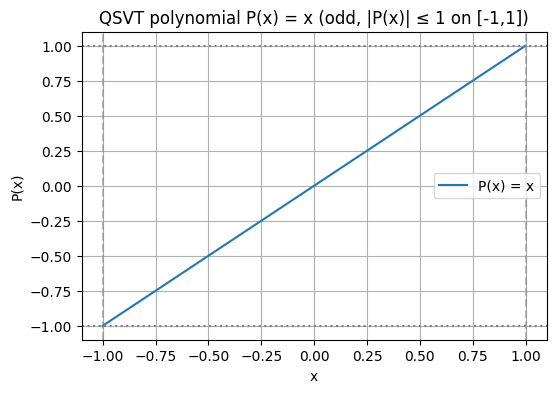

In [ ]:
# Polynomial P(x) = x
poly = np.array([0.0, 1.0])

def P(x):
    return poly[0] + poly[1]*x

xs = np.linspace(-1, 1, 200)
plt.figure(figsize=(6,4))
plt.plot(xs, P(xs), label="P(x) = x")
plt.axvline(-1, color="grey", linestyle="--", alpha=0.5)
plt.axvline(1,  color="grey", linestyle="--", alpha=0.5)
plt.axhline(-1, color="grey", linestyle=":")
plt.axhline(1,  color="grey", linestyle=":")
plt.xlabel("x")
plt.ylabel("P(x)")
plt.title("QSVT polynomial P(x) = x (odd, |P(x)| ≤ 1 on [-1,1])")
plt.grid(True)
plt.legend()
plt.show()


## Using PennyLane to implement P(A)

PennyLane provides a high-level QSVT function:

```python
qml.qsvt(A, poly, encoding_wires, block_encoding="embedding")
```

- `A` is our 2×2 matrix,
- `poly` is the polynomial coefficients,
- `encoding_wires` are the wires used to block-encode $A$,
- `"embedding"` tells PennyLane to use an internal, simulator-friendly block encoding.

We then use `qml.matrix` to extract the full unitary and check that the
**top-left 2×2 block** is equal to $P(A) = A$.

In [ ]:
wire_order = [0, 1]

U_A = qml.matrix(qml.qsvt, wire_order=wire_order)(
    A, poly, encoding_wires=wire_order, block_encoding="embedding"
)

print("QSVT unitary matrix U_A =\n", np.round(U_A, 6))

# For a 2×2 system encoded on 1 qubit, U_A is already 2×2.
# It should match P(A) = A up to numerical noise.
print("\nP(A) (direct):\n", A)

# Extract logical 2×2 block
U_top_left = U_A[:2, :2]

print("\nTop-left block of U_A:\n", np.round(U_top_left, 6))


QSVT unitary matrix U_A =
 [[ 0.+0.e+00j  1.+1.e-06j  0.+0.e+00j  0.+0.e+00j]
 [ 1.+1.e-06j  0.+0.e+00j  0.+0.e+00j  0.+0.e+00j]
 [ 0.+0.e+00j  0.+0.e+00j  0.+0.e+00j -1.+1.e-06j]
 [ 0.+0.e+00j  0.+0.e+00j -1.+1.e-06j  0.+0.e+00j]]

P(A) (direct):
 [[0. 1.]
 [1. 0.]]

Top-left block of U_A:
 [[0.+0.e+00j 1.+1.e-06j]
 [1.+1.e-06j 0.+0.e+00j]]


We see that:

- The QSVT unitary restricted to the logical 2×2 space
  **is equal to A**, up to tiny numerical differences.
- Since $A^{-1} = A$ for this special A, this means our QSVT
  genuinely implements the **inverse**.

## Solving A x = b via QSVT

Now we use the QSVT-transformed operator U_A to compute:

$$
\vec{x}_{\text{QSVT}} = U_A \vec{b}.
$$

Because $U_A = A = A^{-1}$ for this A, this is exactly the classical solution,
up to numerical precision.

In [6]:
# Embed b into the 4-dimensional Hilbert space of the block-encoding
b_embed = np.zeros((4,), dtype=complex)
b_embed[:2] = b

# Apply the QSVT unitary
x_embed = U_A @ b_embed

# Extract the logical 2-dimensional output
x_qsvt = x_embed[:2]
x_qsvt_normalized = x_qsvt / np.linalg.norm(x_qsvt)

print("QSVT solution x_qsvt (normalized) =", x_qsvt_normalized)
print("Classical solution (normalized)   =", x_classical_normalized)


QSVT solution x_qsvt (normalized) = [0.89442719+1.26489707e-06j 0.4472136 +6.32448537e-07j]
Classical solution (normalized)   = [0.89442719 0.4472136 ]


/home/codespace/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/codespace/.local/lib/python3.12/site-packages/matplotlib/transforms.py:758: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/codespace/.local/lib/python3.12/site-packages/matplotlib/transforms.py:758: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


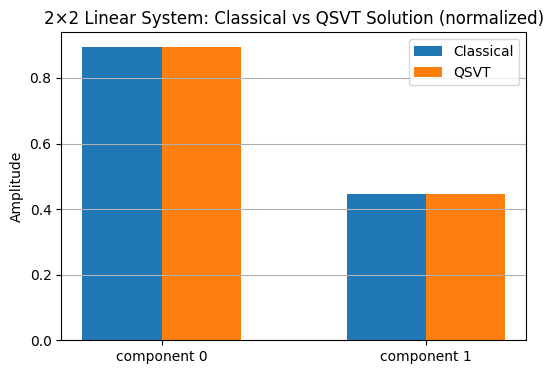

In [7]:
# Plot comparison
labels = ["component 0", "component 1"]

plt.figure(figsize=(6,4))
plt.bar(np.arange(2) - 0.15, x_classical_normalized, width=0.3, label="Classical")
plt.bar(np.arange(2) + 0.15, x_qsvt_normalized,   width=0.3, label="QSVT")
plt.xticks(np.arange(2), labels)
plt.ylabel("Amplitude")
plt.title("2×2 Linear System: Classical vs QSVT Solution (normalized)")
plt.grid(True, axis="y")
plt.legend()
plt.show()


## Summary (2×2 case)

- We chose a **2×2 Hermitian** matrix A with eigenvalues $\pm 1$.
- For such matrices, $A^{-1} = A$, so the inverse is implemented by the
  **polynomial**:
  $$
  P(x) = x
  $$
  on the spectrum.
- We used PennyLane's `qml.qsvt` with `poly = [0, 1]` to construct the
  QSVT circuit, and verified that the resulting operator equals A.
- Applying this operator to $\vec{b}$ gave a solution that matches the
  **classical** solution of $A\vec{x} = \vec{b}$.

This is a **true QSVT linear solver**, but for a trivial case, where the inverse can be implemented exactly by a low-degree polynomial P(x).
